In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout , Flatten
from keras.models import Model
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

In [ ]:
# Define the dataset directories
train_dir = '/content/drive/MyDrive/DataSet/Train'
validation_dir = '/content/drive/MyDrive/DataSet/Validation'
test_dir = '/content/drive/MyDrive/DataSet/Test'

# Check the training dataset directory
print(f'Number of classes in training dataset: {len(os.listdir(train_dir))}')
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    print(f'Number of images in {cls} class: {len(os.listdir(cls_path))}')
    for im in os.listdir(cls_path):
        im_path = os.path.join(cls_path, im)
        try:
            img = Image.open(im_path)
            img.verify() # This line checks if the image is valid
        except Exception as e:
            print(f'Error in opening image {im}: {e}')

print('--------------------------------------------------')

# Check the validation dataset directory
print(f'Number of classes in validation dataset: {len(os.listdir(validation_dir))}')
for cls in os.listdir(validation_dir):
    cls_path = os.path.join(validation_dir, cls)
    print(f'Number of images in {cls} class: {len(os.listdir(cls_path))}')
    for im in os.listdir(cls_path):
        im_path = os.path.join(cls_path, im)
        try:
            img = Image.open(im_path)
            img.verify() # This line checks if the image is valid
        except Exception as e:
            print(f'Error in opening image {im}: {e}')

print('--------------------------------------------------')

# Check the test dataset directory
print(f'Number of classes in test dataset: {len(os.listdir(test_dir))}')
for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    print(f'Number of images in {cls} class: {len(os.listdir(cls_path))}')
    for im in os.listdir(cls_path):
        im_path = os.path.join(cls_path, im)
        try:
            img = Image.open(im_path)
            img.verify() # This line checks if the image is valid
        except Exception as e:
            print(f'Error in opening image {im}: {e}')

Number of classes in training dataset: 2
Number of images in pencil_augmented class: 6341
Number of images in perfume_augmented class: 6284
--------------------------------------------------
Number of classes in validation dataset: 2
Number of images in pencil_augmented class: 2231
Number of images in perfume_augmented class: 2186
--------------------------------------------------
Number of classes in test dataset: 2
Number of images in pencil_augmented class: 1000
Number of images in perfume_augmented class: 1000


In [ ]:
# define the training data flow from the directory
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory='/content/drive/MyDrive/DataSet/Train',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    class_mode='categorical')

# define the validation data flow from the directory
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(directory='/content/drive/MyDrive/DataSet/Validation',
                                                               target_size=(224, 224),
                                                               batch_size=64,
                                                               class_mode='categorical')


# define the Test data flow from the directory
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/DataSet/Test',
                                                               target_size=(224, 224),
                                                               batch_size=64,
                                                               class_mode='categorical')

Found 12625 images belonging to 2 classes.
Found 4417 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# Load the VGG model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Freeze the layers except the last 2 layers
for layer in vgg_model.layers[:-2]:
    layer.trainable = False

In [ ]:
# Add classification layers on top of the VGG model
x = GlobalAveragePooling2D()(vgg_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# Combine the VGG and classification layers
model = Model(inputs=vgg_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

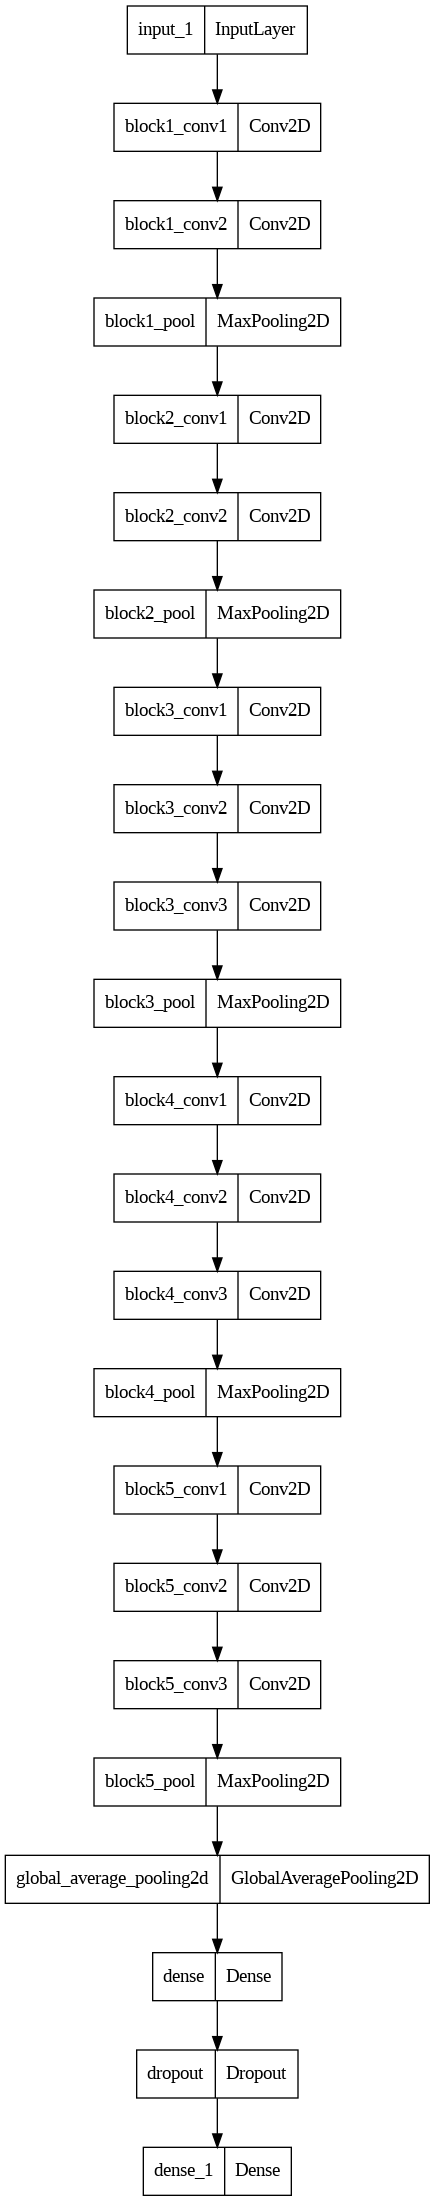

In [ ]:
plot_model(model)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
es = keras.callbacks.EarlyStopping(min_delta = 1e-4, restore_best_weights = True)

# define the checkpoint filepath and monitor metric for early stopping
filepath = "/content/drive/MyDrive/checkpoint_2layers.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# compile the model and include the checkpoint callback
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, steps_per_epoch=60, epochs=5,
                    validation_data=validation_generator, validation_steps=30,
                    callbacks=[es, checkpoint])

Epoch 1/5
60/60 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.9443 
Epoch 1: val_loss improved from inf to 0.00009, saving model to /content/drive/MyDrive/checkpoint_2layers.h5
60/60 [==============================] - 4650s 78s/step - loss: 0.6089 - accuracy: 0.9443 - val_loss: 8.6410e-05 - val_accuracy: 1.0000
Epoch 2/5
60/60 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989 
Epoch 2: val_loss did not improve from 0.00009
60/60 [==============================] - 2946s 49s/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0029 - val_accuracy: 0.9995


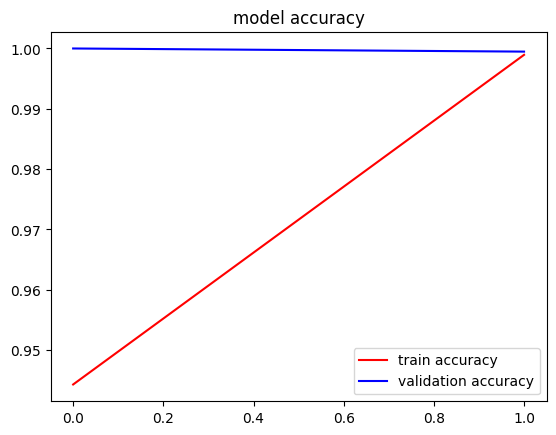

In [ ]:
def acc(model, hist):
  plt.title('model accuracy')
  plt.plot(hist.history['accuracy'], color='r' , label='train accuracy' )
  plt.plot(hist.history['val_accuracy'], color='b' , label='validation accuracy' )
  plt.legend()
  
acc(model, history)

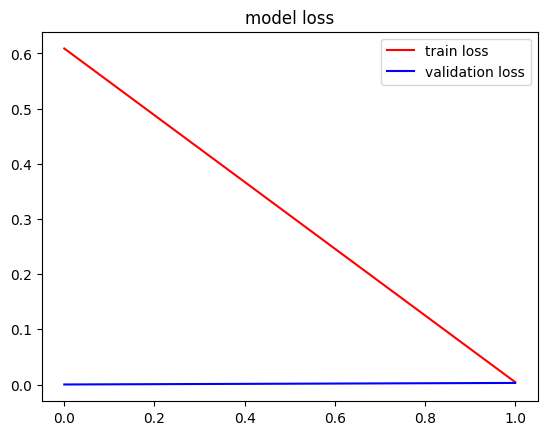

In [ ]:
def loss(model, hist):
  plt.title('model loss')
  plt.plot(hist.history['loss'], color='r' , label='train loss' )
  plt.plot(hist.history['val_loss'], color='b' , label='validation loss' )
  plt.legend()

loss(model, history)

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=100)
print(f'Test accuracy: {test_acc}')

 32/100 [========>.....................] - ETA: 40:51 - loss: 0.0300 - accuracy: 0.9935

100/100 [==============================] - 1119s 11s/step - loss: 0.0300 - accuracy: 0.9935
Test accuracy: 0.9934999942779541
